# Call Libraries

# Import Common Functions

In [117]:
%run Common.ipynb

# Input Parameter

In [118]:
Horizon = 2
Stock_Code = 'VOO'
IsDown = False

In [119]:
analysis_csv_path = f"{RNN_PATH}/{Stock_Code}/Analysis/Model_Result.csv"

## Find best combination for Model training

In [121]:
id, h, d, l, t, p = Fn_GetBest( Horizon , analysis_csv_path )

## For Download Data

In [122]:
Data_Year = 20
end = datetime.now()
NextMonth = 1 if end.month == 12 else end.month + 1
start = datetime.now().replace(year = end.year - Data_Year).replace(day=1).replace(month = NextMonth)

## Save Result variables

In [123]:
 # File 
ThisFolder = f"{RNN_PATH}/{Stock_Code}"
CurrFolder = f"{ThisFolder}/Current"
BackUpName = f"{ThisFolder}/{datetime.now().strftime("%Y%m%d")}"
fileName   = f'RNN_{Stock_Code}'


# Get Data

In [124]:
if IsDown:

    Download_Stock(Stock_Code, start, end , f"{SOURCE_PATH}/{Stock_Code}.csv" )


path = f'{SOURCE_PATH}/{Stock_Code}.csv'


df = pd.read_csv(path)[['Code','Date','Close']]
df['Date'] = pd.to_datetime(df['Date'])

print(f"There are {len(df)} days in total ")

d = d if d < len(df) else len(df)

df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

Input_df = df[-d:].copy()

print(f"Got {len(Input_df)} of days for model training")



There are 3864 days in total 
Got 1402 of days for model training


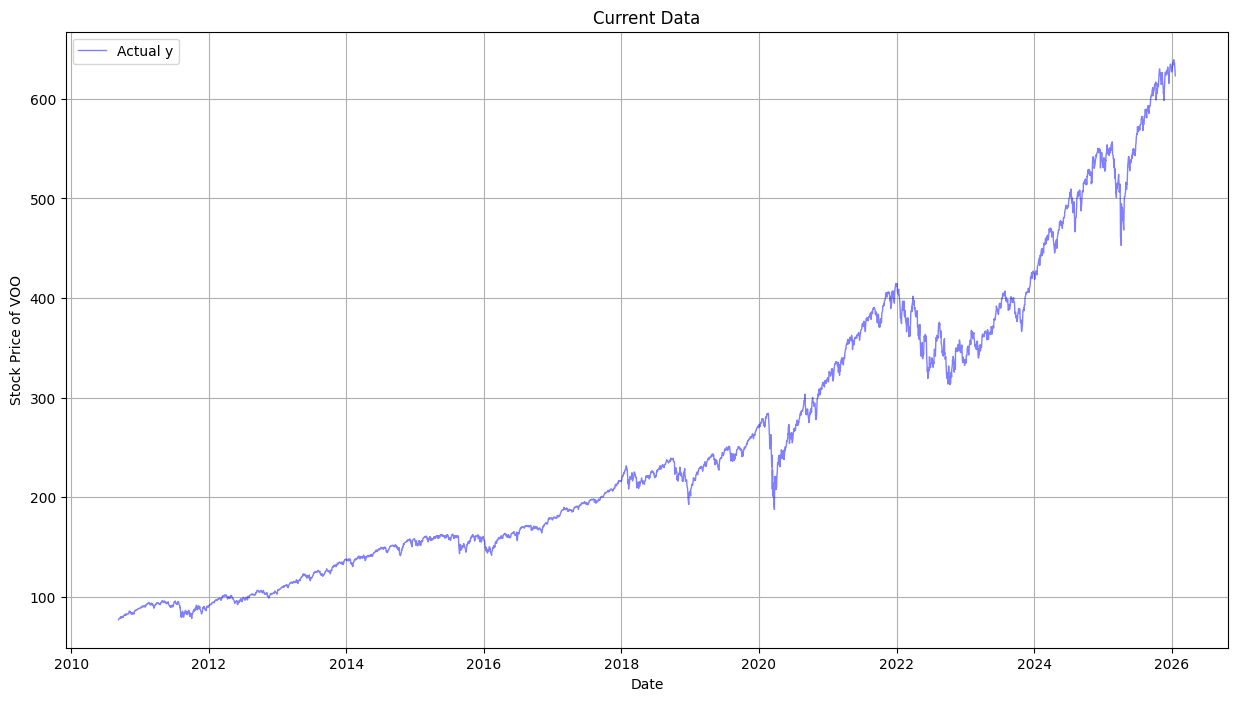

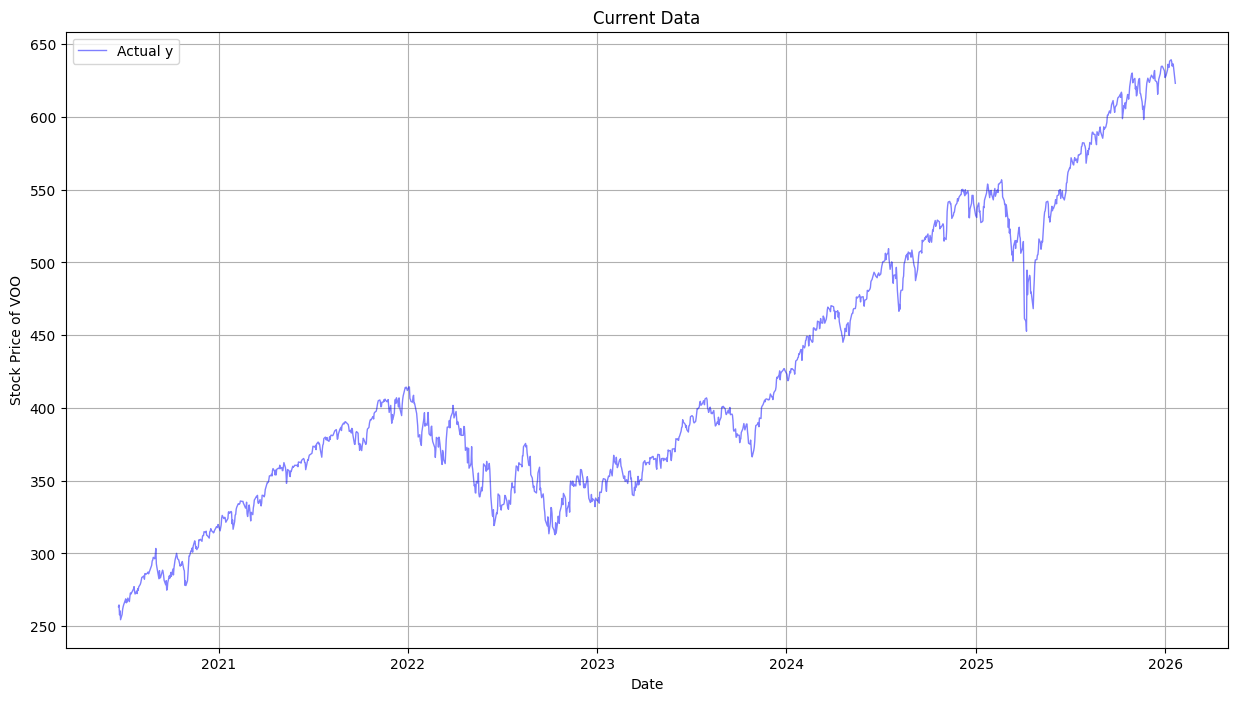

In [125]:
Plot_Result(df, 'Current Data',Stock_Code )
Plot_Result(Input_df, 'Current Data',Stock_Code )

# Train RNN model

In [126]:
%run RNN_Train_Horizon.ipynb

In [127]:
mae, mae_model, model, data_df, indi_df = RNN(Input_df, p , t , Horizon, id , d)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Mean Absolute Error: 5.078 + 5.816


## data

In [128]:
folder_name = f"{id}_H{str(Horizon)}"

result_folder = f"{ThisFolder}/Current/{folder_name}"

RefName = f"Current/{folder_name}/RNN_{Stock_Code}_H{str(Horizon)}"             

Curr_Result = [{
    "id": id,
    "Horizon": Horizon,
    "Refer_Horizon":h,
    "Data_Length":d,
    "Layer": l,
    "Train_Fraction": t,
    "Seq_Len" : p,
    "mae_aggr":mae,
    "mae_indi":mae_model,
    "RefName": RefName,    
}]

# Save Result

In [129]:
if not os.path.exists( result_folder ):

    os.makedirs(  result_folder  )

## Graph

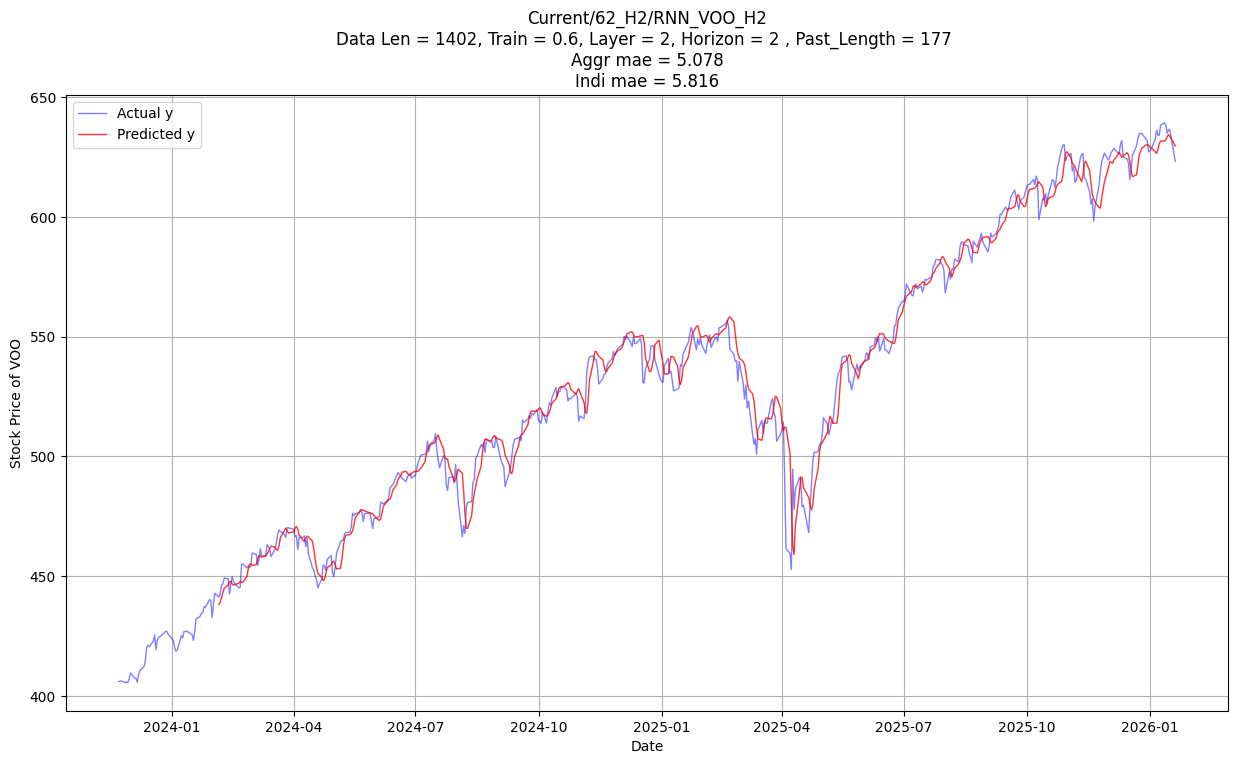

In [130]:
intro_str = f"Data Len = {str(d).ljust(4)}, Train = {t}, Layer = {l}, Horizon = {str(Horizon).ljust(2)}, Past_Length = {str(p).ljust(4)}"
title = f"{RefName}\n{intro_str}\nAggr mae = {round(mae,3)}\nIndi mae = {np.round(mae_model,3)}"

Plot_Result(data_df, title, Stock_Code, model = 'RNN' , name = RefName , IsSave = True)

## Save Model

In [131]:
model.save(f"{result_folder}/{fileName}_H{str(Horizon)}.keras")

## Get Current csv and remove record if same Horizon already exists

In [132]:
trained_csv_path = CurrFolder + '/' + fileName + '.csv' 

newdata_df = pd.DataFrame(Curr_Result)

if os.path.exists(trained_csv_path):
    
    trained_df = pd.read_csv( trained_csv_path )
    cleaned_df = trained_df[trained_df['Horizon'] != Horizon].drop_duplicates()
    
    full_df = pd.concat([cleaned_df,newdata_df], ignore_index = True)

else:
    
    full_df = newdata_df



full_df.to_csv(trained_csv_path, index = False)

